In [152]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Uncertainty

## Types of uncertainty

### Epistemic uncertainty

### Aleatory uncertainty





# Some existing methods for modelling uncertainty

## Monte Carlo Dropout

## Distributional Parameter Learning

## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression


# Uncertainty modelling example

## Function

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$


In [156]:
N_SAMPLES = 200
SIGMA = 0.5  # Data standard deviation
BATCH_SIZE = 16
N_EPOCHS = 100

In [159]:
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu

SyntaxError: EOL while scanning string literal (<ipython-input-159-c5c59f104a42>, line 2)

In [160]:
# Data generating function
def f(x, sigma):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x) #  + (0.1 * x) ** 3
    eps = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return y + eps

In [162]:
# Training data
x_1 = np.random.uniform(-12, -2, size=N_SAMPLES // 2)
x_2 = np.random.uniform(0, 10, size=N_SAMPLES // 2)
x_train = np.concatenate([x_1, x_2]).reshape(N_SAMPLES, 1)
y_train = f(x_train, sigma=SIGMA)

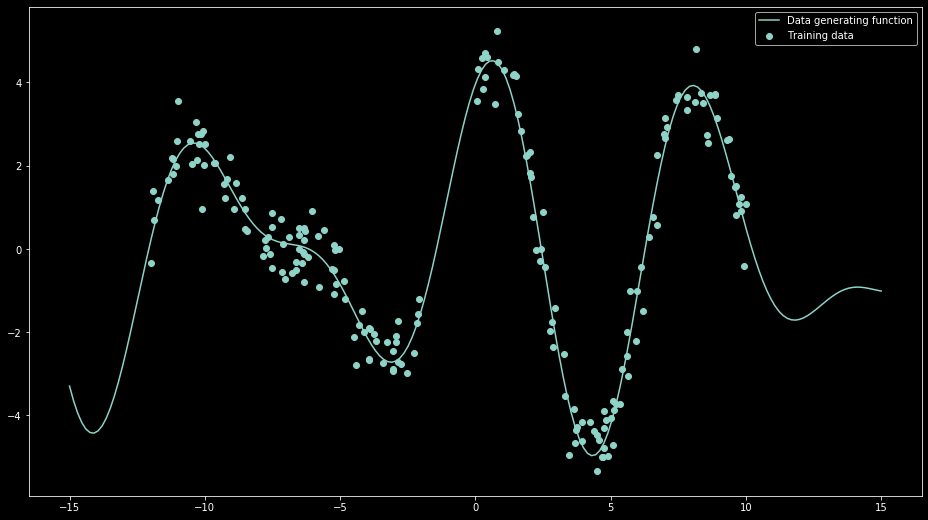

In [163]:
x_plot = np.linspace(-15, 15, num=200)
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, f(x_plot, sigma=0), label='Data generating function')
ax.scatter(x_train, y_train, label='Training data')
ax.legend()

In [164]:
# Dataset and loader
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)

In [142]:
def gaussian_nll(mu_true, mu_pred, sigma_pred):
    return np.log(sigma_pred ** 2) / 2 + ((mu_true - mu_pred) ** 2) / (2 * sigma_pred ** 2)

In [143]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, mu_pred, logvar_pred):
        return torch.mean(logvar_pred / (2 * np.pi) + (mu_true - mu_pred).pow(2) / (2 * logvar_pred.exp()), axis=0)

In [165]:
class DPLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.act1 = nn.ELU()
        self.lin2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        mu = x[..., 0:1]
        logvar = x[..., 1:2]
        return mu, logvar

In [167]:
model = DPLModel()
model.to(device)

gaussian_nll_loss = GaussianNLLLoss()
gaussian_nll_loss.to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-5)

for epoch in range(N_EPOCHS):
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader_train, start=1):
        x_batch.to(device)
        y_batch.to(device)

        optimizer.zero_grad()

        mu_pred, logvar_pred = model.forward(x_batch)
        loss = gaussian_nll_loss(y_batch, mu_pred, logvar_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss[0].item()

    print(f'Epoch {epoch:3d} | Loss {total_loss / i} ({loss[0].item()})', end='\r')
    

Epoch   0 | Loss 3.800220782940204 (5.628769874572754)Epoch   1 | Loss 3.783227672943702 (5.596912860870361)Epoch   2 | Loss 3.7675397304388194 (5.5656561851501465)Epoch   3 | Loss 3.7522477370042067 (5.535107135772705)Epoch   4 | Loss 3.737265495153574 (5.50523042678833)Epoch   5 | Loss 3.7225571412306566 (5.475980758666992)Epoch   6 | Loss 3.7080992460250854 (5.447316646575928)Epoch   7 | Loss 3.693874854307908 (5.4192118644714355)Epoch   8 | Loss 3.679869349186237 (5.39163875579834)Epoch   9 | Loss 3.666069370049697 (5.364584922790527)Epoch  10 | Loss 3.6524608502021203 (5.338034629821777)Epoch  11 | Loss 3.6390293561495266 (5.311978816986084)Epoch  12 | Loss 3.6257575016755323 (5.286412715911865)

KeyboardInterrupt: 

In [0]:
with torch.no_grad():
    x_plot_tensor = torch.Tensor(x_plot.reshape(-1, 1))
    x_plot_tensor.to(device)
    learned_function, epistemic_logvar = model.forward(x_plot_tensor)
    learned_function = learned_function.flatten()
    epistemic_std = epistemic_logvar.flatten().exp().sqrt()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, f(x_plot, sigma=0), label='Data generating function')
ax.fill_between(x_plot, learned_function - epistemic_std, learned_function + epistemic_std, label='Epistemic uncertainty')
ax.scatter(x_train, y_train, label='Training data')
ax.plot(x_plot, learned_function, label='Learned mean function')
ax.set_ylim([-10, 10])
ax.legend()